In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['TRANSFORMERS_OFFLINE'] = '1'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import transformer_lens
import datasets
from load import *
from analysis.load_results import (
    load_probing_experiment_results, 
    make_heuristic_probing_results_df
)
from activations.activation_subset import load_activation_subset, load_neuron_subset_csv
from analysis.plots import *

In [4]:
model_name = 'pythia-1.4b'
dataset_name = 'pile_test.pyth.512.-1'
experiment_name = 'layer_1_neuron_0_pile_test_activations'
act_subset_dict, metadata, token_summary_df = load_activation_subset('results', model_name, dataset_name, experiment_name, 'activation_subset')
feature_dataset = load_feature_dataset(dataset_name)

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [5]:
model = load_model('pythia-70m')  # all models have same tokenizer so just use smallest model

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


In [6]:
(3_000_000 * 24 * 1024 * 4) / 2**30

274.658203125

In [7]:
activations = act_subset_dict[1, 0]

decoded_vocab = {t: model.tokenizer.decode(t) for t in model.tokenizer.get_vocab().values()}
activation_df = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations.flatten().numpy().astype(np.float16),
})



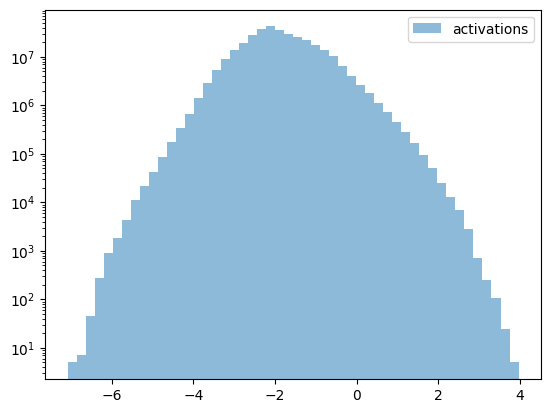

In [9]:
c, bins, ax = plt.hist(activation_df['activation'], bins=50, alpha=0.5, label='activations')
#plt.hist(np.random.normal(loc=-0.73, scale=0.82, size=len(activation_df['activation'])), bins=bins, alpha=0.5, label='test normal');
plt.legend()
#plt.yscale('log')


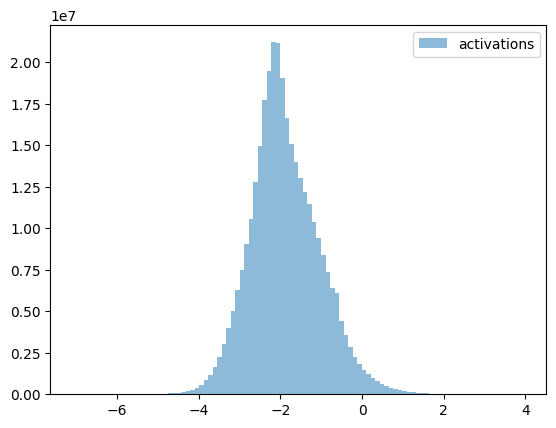

In [14]:
c, bins, ax = plt.hist(activation_df['activation'], bins=100, alpha=0.5, label='activations')
plt.legend()


In [9]:
(activation_df['activation'] > 3).mean()

1.7153503561572917e-06

In [8]:
np.max(activation_df['activation'].values)

3.963

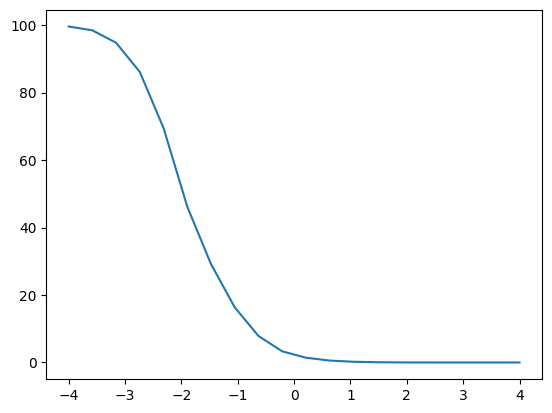

In [18]:
p = np.linspace(-4, 4, 20)
cdf = [(activation_df['activation'] > i).mean() * 100 for i in p]


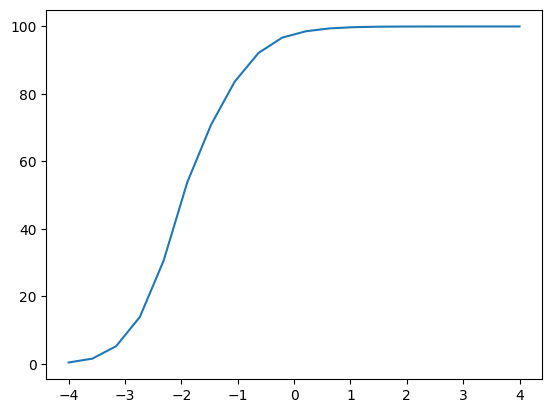

In [23]:
plt.plot(p, 100-np.array(cdf), label='activations')

In [10]:
(activation_df.memory_usage() / 2**30).round(2)

Index         0.00
token         0.62
activation    0.62
dtype: float64

In [10]:
token_summary_df['upper_quartile_range'] = token_summary_df['max'] - token_summary_df['75%']

Text(0, 0.5, 'upper quartile range')

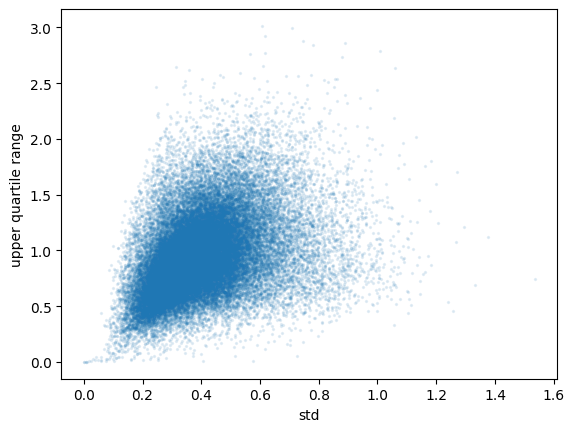

In [11]:
plt.scatter(token_summary_df['std'], token_summary_df['upper_quartile_range'], alpha=0.1, s=2)
plt.xlabel('std')
plt.ylabel('upper quartile range')

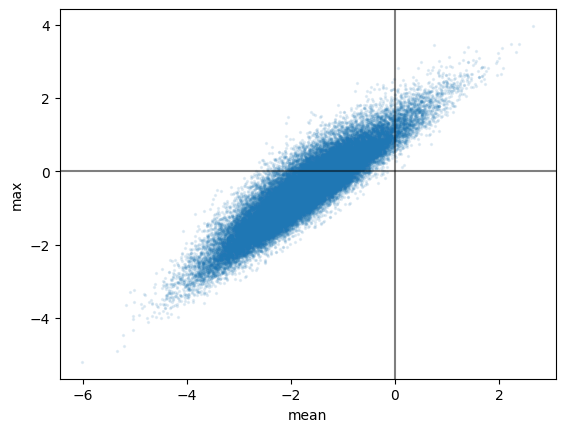

In [12]:
plt.scatter(token_summary_df['mean'], token_summary_df['max'], alpha=0.1, s=2)
plt.xlabel('mean')
plt.ylabel('max')
plt.axvline(0, color='black', alpha=0.5)
plt.axhline(0, color='black', alpha=0.5)

In [13]:
np.corrcoef(token_summary_df['mean'].values, token_summary_df['max'].values)

array([[1.        , 0.91307626],
       [0.91307626, 1.        ]])

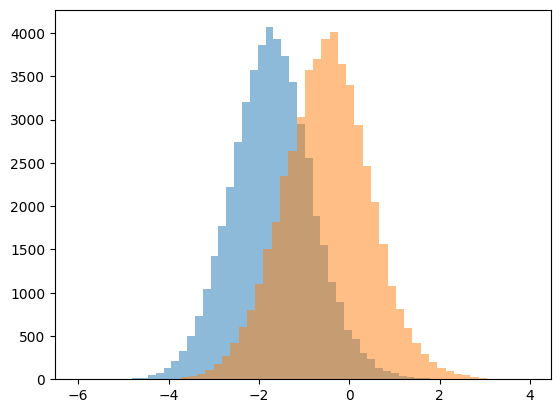

In [16]:
plt.hist(token_summary_df['mean'], bins=50, alpha=0.5) 
plt.hist(token_summary_df['max'], bins=50, alpha=0.5);

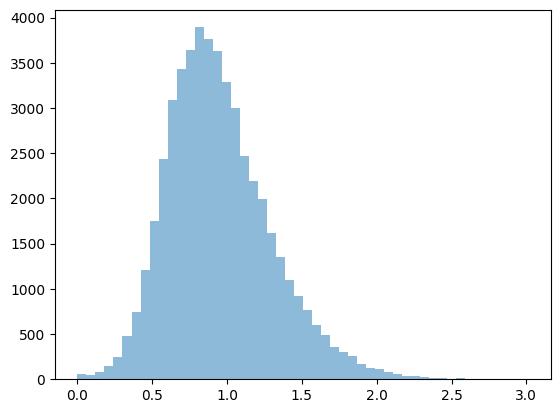

In [15]:
plt.hist(token_summary_df['upper_quartile_range'], bins=50, alpha=0.5);

In [24]:
token_summary_df.sort_values('max', ascending=False).head(3).token.values

array([27272, 45933, 14688])

In [27]:
for ix, token in enumerate(token_summary_df.sort_values('max', ascending=False).head(3).token.values):
    print_minmax_activations_for_token(token, activation_df, feature_dataset, model, 6, 2, 5, 5)


########### Activations for 27272: " rotated" ###########
### Max activations for 27272: " rotated" ###
BEGIN (3.962890625): , causing it to drill when| rotated|.
BEGIN (3.912109375):  that when the drill bit is| rotated| by
BEGIN (3.873046875):  may be employed which, when| rotated|,
BEGIN (3.86328125):  and the drill bit may be| rotated| using
BEGIN (3.7421875):  bit as the drill bit is| rotated|.
### Min activations for 27272: " rotated" ###
BEGIN (0.9921875): ) supplemented with protease inhibitors and| rotated| for
BEGIN (0.99658203125):  here the spin axis can be| rotated| by
BEGIN (1.0546875):  state. The result is the| rotated| spin
BEGIN (1.0615234375):  of the quantum walk in this| rotated| basis
BEGIN (1.09375):  These observables are represented by the| rotated| quadr
########### Activations for 45933: " rotates" ###########
### Max activations for 45933: " rotates" ###
BEGIN (3.48046875):  that a portion of the crank| rotates| in
BEGIN (3.33984375):  pipes to an hydraulic 

In [19]:
max_activating.sort_values(('upper_quartile_range'), ascending=False).head(25)

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string,upper_quartile_range,is_alphabetical
5737,1,0,5791,12441.0,-0.732726,0.565812,-2.843093,-1.105650,-0.768108,-0.345746,2.415387,East,2.761133,True
7162,1,0,7222,9243.0,-0.394106,0.689469,-2.245893,-0.790216,-0.627007,-0.317158,2.246643,pas,2.563801,True
24333,1,0,24485,855.0,-0.452823,0.475607,-1.568561,-0.749533,-0.542422,-0.265366,2.292487,iciency,2.557853,True
27192,1,0,27359,2088.0,-0.306691,0.622423,-1.377573,-0.611327,-0.458512,-0.267248,2.253134,nur,2.520382,True
9093,1,0,9167,6806.0,-0.765120,0.760027,-2.895158,-1.289000,-0.921947,-0.290929,2.194512,Cup,2.485441,True
19242,1,0,19368,1763.0,-0.538224,0.513324,-2.401407,-0.816255,-0.480108,-0.232033,2.179194,Phase,2.411227,True
937,1,0,958,56020.0,0.067215,0.613050,-1.874945,-0.356518,0.075705,0.473167,2.812111,fact,2.338945,True
14283,1,0,14384,3219.0,-0.226102,0.566790,-1.878906,-0.616941,-0.256261,0.134973,2.339723,deficiency,2.204750,True
5934,1,0,5991,8838.0,-0.078548,0.579358,-1.168399,-0.430089,-0.254455,0.070160,2.215887,à,2.145726,True
536,1,0,553,12074.0,-0.487438,0.801058,-3.502465,-0.864973,-0.295372,0.054467,2.160193,ime,2.105726,True


In [17]:
is_alphabetical = [
    all(c.isalpha() or c.isspace() for c in t_str) 
    if isinstance(t_str, str) else False 
    for t_str in token_summary_df['string'].values
]

token_summary_df['is_alphabetical'] = is_alphabetical

# Most interested in tokens with high max and either high variance or high upper quartile range
max_activating = token_summary_df.query('(count > 10) and is_alphabetical').sort_values('max', ascending=False).head(250)
max_std_tokens = max_activating.sort_values(('std'), ascending=False).head(25).token.values
max_quartile_range_tokens = max_activating.sort_values(('upper_quartile_range'), ascending=False).head(25).token.values
interesting_tokens = set(max_std_tokens) | set(max_quartile_range_tokens)

tokens_of_interest_df = token_summary_df.query('token in @interesting_tokens')
tokens_of_interest_df.sort_values('max', ascending=False)

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string,upper_quartile_range,is_alphabetical
2582,1,0,2616,37129.0,0.755252,0.737800,-1.857860,0.316518,0.759867,1.466345,3.452216,factors,1.985871,True
41364,1,0,41586,566.0,1.401555,0.859672,-0.928719,0.841159,1.329347,1.977480,3.382575,factors,1.405095,True
19732,1,0,19860,1865.0,1.330784,0.767258,-1.028315,0.784262,1.393560,1.939158,3.242210,splitting,1.303053,True
13231,1,0,13324,2450.0,1.984871,0.794261,-0.494760,1.536030,2.286988,2.556031,3.223602,lat,0.667571,True
2289,1,0,2321,1891.0,1.566392,0.769089,-0.853201,1.136487,1.794096,2.116280,3.002757,aug,0.886477,True
2766,1,0,2803,31151.0,0.850736,0.947930,-1.631867,0.220446,0.780822,1.363760,3.001000,factor,1.637240,True
31738,1,0,31923,349.0,0.505162,0.978462,-1.104240,-0.275534,0.377563,1.258545,2.974927,esti,1.716382,True
17431,1,0,17551,2155.0,1.050382,0.758204,-1.314288,0.739979,1.179250,1.537470,2.858453,jan,1.320983,True
9074,1,0,9148,6298.0,1.091744,0.743452,-0.727709,0.459844,0.781340,1.842776,2.846182,split,1.003406,True
937,1,0,958,56020.0,0.067215,0.613050,-1.874945,-0.356518,0.075705,0.473167,2.812111,fact,2.338945,True


In [21]:


def print_minmax_activations_for_token(token, activation_df, feature_dataset, model,
     print_n_tokens_before=3, print_n_tokens_after=5, top_k=10, bottom_k=10):
    t_str = model.tokenizer.decode(token)
    n_seqs, n_pos = feature_dataset['tokens'].shape
    print(f'########### Activations for {token}: "{t_str}" ###########')
    max_activating = activation_df.query('token==@token').sort_values('activation', ascending=False).head(top_k)
    min_activating = activation_df.query('token==@token').sort_values('activation').head(bottom_k)

    print(f'### Max activations for {token}: "{t_str}" ###')
    for s, p in zip((max_activating.index.values // n_pos).tolist(), 
                    (max_activating.index.values % n_pos).tolist()):
        prefix = model.tokenizer.decode(feature_dataset[s]['tokens'][p-print_n_tokens_before:p])
        suffix = model.tokenizer.decode(feature_dataset[s]['tokens'][p+1:p+print_n_tokens_after])
        print(f'BEGIN ({activations[s, p]}): {prefix}|{t_str}|{suffix}')

    print(f'### Min activations for {token}: "{t_str}" ###')
    for s, p in zip((min_activating.index.values // n_pos).tolist(), 
                    (min_activating.index.values % n_pos).tolist()):
        prefix = model.tokenizer.decode(feature_dataset[s]['tokens'][p-print_n_tokens_before:p])
        suffix = model.tokenizer.decode(feature_dataset[s]['tokens'][p+1:p+print_n_tokens_after])
        print(f'BEGIN ({activations[s, p]}): {prefix}|{t_str}|{suffix}')

for ix, token in enumerate(np.array(list(interesting_tokens)).astype(np.uint16)):
    print_minmax_activations_for_token(token, activation_df, feature_dataset, model, 6, 2, 5, 5)


    

########### Activations for 10372: " Chapter" ###########
### Max activations for 10372: " Chapter" ###
BEGIN (2.115234375): k, Austin, Tex.,| Chapter| 7
BEGIN (1.9609375):  cases concern the right of a| Chapter| 13
BEGIN (1.935546875):  the [Texas Education Code],| Chapter| 
BEGIN (1.93359375): the [Texas Education Code],| Chapter| 21
BEGIN (1.8671875):  type of suit is controlled by| Chapter| 14
### Min activations for 10372: " Chapter" ###
BEGIN (-2.1171875):  e)$ (see [@Gl| Chapter| 1
BEGIN (-2.11328125):  the next Lemma and briefly in| Chapter| \[
BEGIN (-2.0390625):  notion is described in [@Gl| Chapter| IX
BEGIN (-2.0078125):  Following Lance [@Lan95| Chapter| 4
BEGIN (-1.9755859375): .6] and [@Gl| Chapter| 1
########### Activations for 1162: " et" ###########
### Max activations for 1162: " et" ###
BEGIN (2.447265625): 
REYNAGA;| et| al
BEGIN (2.423828125): 
Montana, LLC;| et| al
BEGIN (2.421875): OBIN SANDY;| et| al
BEGIN (2.408203125): CS 5/122-1| et| seq
BEGIN (2.380859375):

In [28]:
token_summary_df['is_alphabetical'] = is_alphabetical

bigram_dfs = {}
for t in list(interesting_tokens):
    start_t = time.time()
    t_adf = copy.deepcopy(activation_df.query('token==@t'))
    t_adf['prefix'] = activation_df.loc[t_adf.index.values - 1, 'token'].values
    bigram_df = t_adf.groupby('prefix').activation.describe().query('count > 2').sort_values('max', ascending=False).head(10)
    bigram_dfs[t] = bigram_df
    print(f'Finished processing token {t} in {time.time() - start_t:.2f} seconds ({len(t_adf)} occurrences)')
    
top_bigram_df = pd.concat(bigram_dfs)
top_bigram_df.index.names = ['suffix', 'prefix']
top_bigram_df['prefix_str'] = [f"'{decoded_vocab[p]}'" for p in top_bigram_df.index.get_level_values('prefix')]
top_bigram_df['suffix_str'] = [f"'{decoded_vocab[s]}'" for s in top_bigram_df.index.get_level_values('suffix')]



Finished processing token 10372 in 2.08 seconds (5697 occurrences)
Finished processing token 1162 in 7.02 seconds (78552 occurrences)
Finished processing token 13324 in 1.82 seconds (2450 occurrences)
Finished processing token 17551 in 1.86 seconds (2155 occurrences)
Finished processing token 2321 in 1.77 seconds (1891 occurrences)
Finished processing token 19860 in 1.95 seconds (1865 occurrences)
Finished processing token 2069 in 3.74 seconds (47101 occurrences)
Finished processing token 1307 in 3.39 seconds (32208 occurrences)
Finished processing token 5791 in 2.56 seconds (12441 occurrences)
Finished processing token 41376 in 1.69 seconds (450 occurrences)
Finished processing token 1185 in 2.22 seconds (4164 occurrences)
Finished processing token 39844 in 1.68 seconds (637 occurrences)
Finished processing token 24485 in 1.63 seconds (855 occurrences)
Finished processing token 19368 in 2.00 seconds (1763 occurrences)
Finished processing token 553 in 2.00 seconds (12074 occurrences)
F

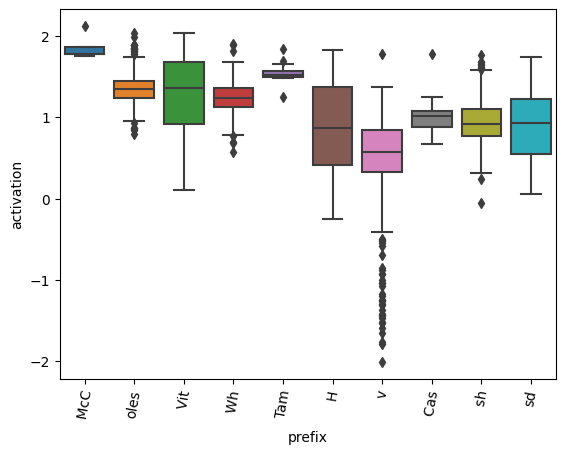

In [29]:
token = 3181
bigram_df = bigram_dfs[token]

t_adf = copy.deepcopy(activation_df.query('token==@token'))
t_adf['prefix'] = activation_df.loc[t_adf.index.values - 1, 'token'].values

valid_prefix_tokens = set(bigram_dfs[token].index.values)
token_strs = [decoded_vocab[t] for t in valid_prefix_tokens]

ax = sns.boxplot(t_adf, x='prefix', y='activation', order=bigram_dfs[token].index.values)
ax.set_xticklabels([decoded_vocab[int(t.get_text())].replace('$', '\$') for t in ax.get_xticklabels()], rotation=80);

/var/folders/8f/qz9dtbzx2s77drzzcdl8xztm0000gn/T/ipykernel_14459/3712946676.py:19: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/var/folders/8f/qz9dtbzx2s77drzzcdl8xztm0000gn/T/ipykernel_14459/3712946676.py:19: UserWarning: Glyph 12 () missing from current font.
  plt.tight_layout()
/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12 () missing from current font.
  func(*args, **kwargs)
/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wesgurnee/Documents/mechint/sparse_probin

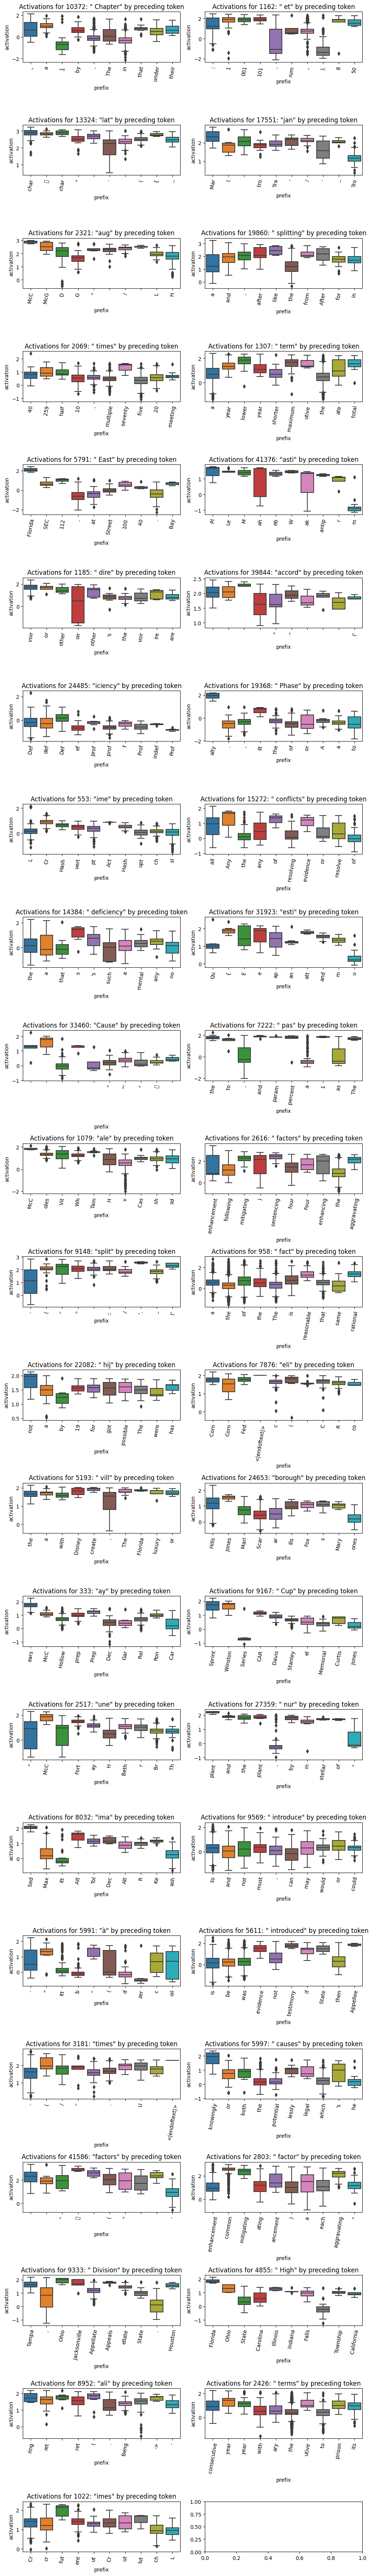

In [30]:
import math
cols = 2
rows = math.ceil(len(interesting_tokens) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
for ix, token in enumerate(interesting_tokens):

    bigram_df = bigram_dfs[token]

    t_adf = copy.deepcopy(activation_df.query('token==@token'))
    t_adf['prefix'] = activation_df.loc[t_adf.index.values - 1, 'token'].values

    valid_prefix_tokens = set(bigram_dfs[token].index.values)
    token_strs = [decoded_vocab[t] for t in valid_prefix_tokens]

    ax = axes[ix//2, ix%2]
    sns.boxplot(t_adf, x='prefix', y='activation', order=bigram_dfs[token].index.values, ax=ax)
    ax.set_xticklabels([decoded_vocab[int(t.get_text())].replace('$', '\$') for t in ax.get_xticklabels()], rotation=80);
    ax.set_title(f'Activations for {token}: "{decoded_vocab[token]}" by preceding token')
plt.tight_layout()

In [32]:
2426

2426

In [33]:

def make_ngram_adf(activation_df, t, n_gram=4):
    col_names = [f'prefix-{i}' for i in range(n_gram-1, 0, -1)]
    t_adf = copy.deepcopy(activation_df.query('token==@t'))
    for i in range(n_gram-1, 0, -1):
        t_adf[f'prefix-{i}'] = activation_df.loc[t_adf.index.values - i, 'token'].values
    ngram_adf = t_adf.groupby(col_names).activation.describe().query('count > 2').sort_values('max', ascending=False).head(10)
    ngram_adf['string'] = [
        f"{', '.join([decoded_vocab[p] for p in ngram])}" 
        if isinstance(ngram, tuple) else decoded_vocab[ngram] 
        for ngram in ngram_adf.index.values]
    return ngram_adf

In [34]:
t = 2426

In [35]:
ngram_adf = make_ngram_adf(activation_df, t, n_gram=2)
ngram_adf

,count,mean,std,min,25%,50%,75%,max,string
prefix-1,,,,,,,,,
12640,43.0,0.953613,0.662598,-0.521973,0.604248,0.900879,1.373047,2.250000,consecutive
807,14.0,1.331055,0.507324,0.330078,0.934814,1.434082,1.596436,2.207031,year
2913,75.0,1.151367,0.364014,0.272217,0.896973,1.149414,1.319336,2.167969,year
342,48.0,0.552246,0.695801,-1.581055,0.220001,0.526245,0.938477,2.119141,with
552,9.0,0.677734,0.882812,-0.421875,0.274902,0.516113,0.963867,2.105469,ary
253,9644.0,0.462646,0.427979,-1.420898,0.252197,0.361084,0.646729,2.080078,the
4995,7.0,1.182617,0.509766,0.597656,0.886230,1.006836,1.421387,2.064453,utive
281,503.0,0.386719,0.434814,-1.263672,0.157959,0.440674,0.645752,2.025391,to
5754,70.0,1.083984,0.420898,0.253906,0.742065,1.005615,1.382080,1.973633,prison


In [391]:
ngram_adf.index.values[:4]

array([ 15, 605,  16,   0], dtype=uint64)

In [36]:
ngram_adf = make_ngram_adf(activation_df, t, n_gram=3)
ngram_adf

,,count,mean,std,min,25%,50%,75%,max,string
prefix-2,prefix-1,,,,,,,,,
281,12640,6.0,1.846680,0.433105,1.201172,1.592773,1.927734,2.199707,2.250000,"to, consecutive"
19,807,3.0,1.859375,0.311035,1.606445,1.686035,1.765625,1.986328,2.207031,"2, year"
14,2913,75.0,1.151367,0.364014,0.272217,0.896973,1.149414,1.319336,2.167969,"-, year"
13,342,6.0,0.891113,0.801270,0.205078,0.291443,0.576050,1.399536,2.119141,",, with"
323,253,34.0,0.128906,0.708984,-1.196289,-0.298828,-0.079895,0.520569,2.080078,"for, the"
13588,253,38.0,1.289062,0.403320,0.304199,1.056396,1.334473,1.551514,2.078125,"violated, the"
407,253,140.0,0.909180,0.583008,-0.990234,0.774048,0.982422,1.288330,2.074219,"by, the"
1704,4995,7.0,1.182617,0.509766,0.597656,0.886230,1.006836,1.421387,2.064453,"sec, utive"
767,12640,11.0,0.595703,0.712402,-0.521973,0.088989,0.757812,0.882812,2.039062,"two, consecutive"


In [393]:
ngram_adf.index.values[:3]

array([(35654, 15), (2700, 15), (681, 15)], dtype=object)

In [37]:
ngram_adf = make_ngram_adf(activation_df, t, n_gram=4)
ngram_adf

,,,count,mean,std,min,25%,50%,75%,max,string
prefix-3,prefix-2,prefix-1,,,,,,,,,
16290,281,12640,5.0,1.974609,0.331055,1.570312,1.660156,2.195312,2.201172,2.250000,"sentenced, to, consecutive"
16,19,807,3.0,1.859375,0.311035,1.606445,1.686035,1.765625,1.986328,2.207031,"/, 2, year"
2620,14,2913,13.0,1.160156,0.471924,0.504883,0.826660,1.155273,1.217773,2.167969,"five, -, year"
767,14,2913,11.0,1.173828,0.355713,0.817871,0.993896,1.099609,1.193359,2.148438,"two, -, year"
574,13588,253,11.0,1.202148,0.530762,0.304199,0.884277,1.421875,1.449707,2.078125,"had, violated, the"
585,1704,4995,7.0,1.182617,0.509766,0.597656,0.886230,1.006836,1.421387,2.064453,"con, sec, utive"
281,767,12640,3.0,1.231445,0.702637,0.757812,0.828369,0.898926,1.468750,2.039062,"to, two, consecutive"
3578,14,2913,3.0,1.519531,0.424805,1.151367,1.287109,1.422852,1.703613,1.984375,"ten, -, year"
187,3113,253,3.0,1.221680,0.635742,0.796875,0.855957,0.915039,1.433594,1.952148,"\n, with, the"


In [380]:
ngram_adf.index.values[:3]

array([(43950, 762, 253), (3567, 762, 253), (2256, 281, 253)],
      dtype=object)

In [456]:
# token_ix: [list of prefixes to create classes for]
# each list containts a set of prefixes
# where a prefix is a tuple of tokens
neuron_stimuli = {
    12299: [[(13804,), (9432,)]],  # e.g. {Har, har}|vard
    35476: [[(43950, 762, 253), (3567, 762, 253)], [(2256, 281, 253)]],  # Boost
    20740: [[(2058, 253, 5403), (3404, 253, 5403)]], # census
    26268: [[(15, 12332, 9824)], [(32170, 9824)]], # Chain d
    412: [[(47678, ), (14029, )]], # op
    20000: [[(38476, 5625)]], # Peace
    3621: [[(47694, )]], # lease
    13606: [[(5625, 330)]], # oven
    14894: [[(12602, 273, 15123)]], # hma
    2616: [[(4335, )], [(29602, )]], # factors d
    7736: [[(21698, )]], # pogenic
    39098: [[(4146, 12761), (14594, 12761)]], # systems
    4412: [[(11586, 2077)]], # District
    15353: [[(36642, )]], # gate
    11845: [[(19256, 38056)]], # iallance
    4694: [[(47678, ), (14029, )]], # vision 
    20310: [[(5625, 10518), (22817, 10518)]], # Mach
    6875: [[(7671, ), (31351, )]], # Science
    17629: [[(6399, )]], # ograms
    19934: [[(35654, 15)], [(2700, 15)]], # apple , 
    48862: [[(45590, 64)]], # AUX
    7404: [[(749, ), (2377, )]], # process
    35437: [[(22817, 13940), (5625, 13940)]], # communication
    7662: [[(2359, 412), (22468, 412)]], # roduction
    25837: [[(681, 16)]], # fw
    16240: [[(21034, )], [(20709, )]], # ington d
}

In [2]:
(50_000 * 50_000)

2500000000

In [364]:
t = 16240

# for prefix in neuron_stimuli[t][0]:
#     print(' '.join([decoded_vocab[p] for p in prefix]))

In [453]:
neuron_stimuli = {
    12299: [[(13804,), (9432,)]],  # e.g. {Har, har}|vard
    35476: [[(43950, 762, 253), (3567, 762, 253)], [(2256, 281, 253)]],  # Boost
    20740: [[(2058, 253, 5403), (3404, 253, 5403)]], # census
}

In [457]:
stimuli_order = token_summary_df.loc[token_summary_df.token.isin(neuron_stimuli.keys())].sort_values('max', ascending=False).token.values

Text(0.5, 1, 'Activation distribution of neuron 1.111 by token colored by prefix')

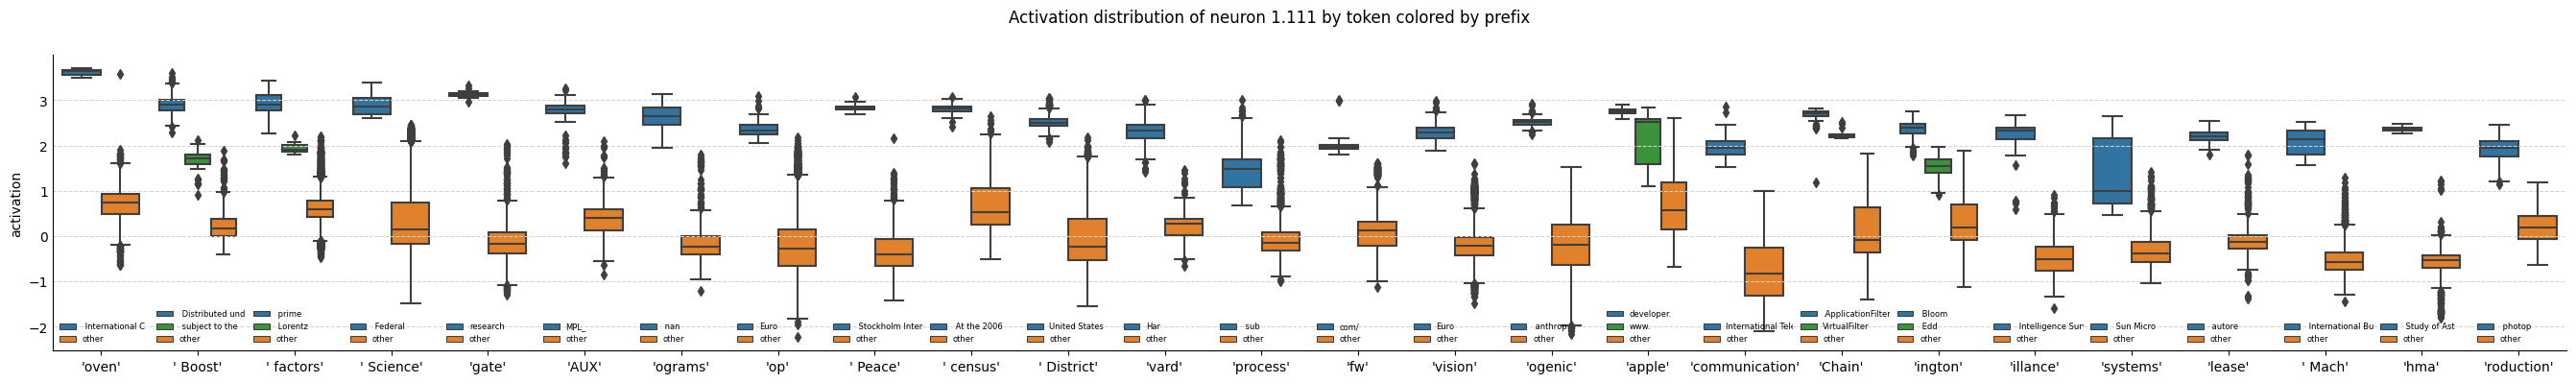

In [459]:
fig, axs = plt.subplots(1, len(neuron_stimuli), figsize=(1.3 * len(neuron_stimuli), 4), sharey=True)
order_priorities = []
for ix, t in enumerate(stimuli_order):
    t_adf = copy.deepcopy(activation_df.query('token==@t'))
    t_adf['class_label'] = 'other'  # start with other by default
    stimulus_order = []
    for stimulus in neuron_stimuli[t]:
        n_gram = max(len(p) for p in stimulus)
        for i in range(n_gram, 0, -1):
            t_adf[f'prefix-{i}'] = activation_df.loc[t_adf.index.values - i, 'token'].values

        # use first prefix in the set as class label
        stimulus_string =  f"{''.join([decoded_vocab[p] for p in stimulus[0]])}" 
        stimulus_order.append(stimulus_string)

        for prefix in stimulus:
            if len(prefix) == 1:
                t_adf.loc[t_adf['prefix-1'] == prefix[0], 'class_label'] = stimulus_string
            elif len(prefix) == 2:
                t_adf.loc[
                    (t_adf['prefix-2'] == prefix[0]) & 
                    (t_adf['prefix-1'] == prefix[1]), 
                    'class_label'
                ] = stimulus_string
            elif len(prefix) == 3:
                t_adf.loc[
                    (t_adf['prefix-3'] == prefix[0]) & 
                    (t_adf['prefix-2'] == prefix[1]) & 
                    (t_adf['prefix-1'] == prefix[2]), 
                    'class_label'
                ] = stimulus_string
            else:
                raise ValueError(f"prefix length {len(prefix)} not supported")

    # used to reorder the subplots after plotting
    max_class_median_activation = t_adf.groupby('class_label').activation.median().max()
    order_priorities.append(max_class_median_activation)

    stimulus_order.append('other')
    # see https://stackoverflow.com/questions/46173419/seaborn-change-color-according-to-hue-name
    # always want orange to be the last color
    palette = ["C0", "C2", "C1"] if len(stimulus_order) == 3 else ["C0", "C1"]
    ax = axs[ix]
    sns.boxplot(
        t_adf, x='token', y='activation', hue='class_label', 
        hue_order=stimulus_order, palette=palette, ax=ax
    )
    ax.legend(loc='lower left', prop={'size': 6}, frameon=False)

    # formatting
    ax.set_xlabel('')
    ax.set_xticklabels([f"'{decoded_vocab[t]}'"])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
    ax.tick_params(axis='y', which='both', length=0)
    if ix > 0:
        ax.set_ylabel('')
        ax.spines['left'].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)

# reorder subplots by order_priorities
# subplot_permutation = np.argsort(np.array(order_priorities))[::-1]
# new_positions = {ax_ix: axs[top_ix].get_position() for ax_ix, top_ix in enumerate(subplot_permutation)}
# for ax_ix, top_ix_plot_position in new_positions.items():
#     axs[ax_ix].set_position(top_ix_plot_position)

plt.suptitle('Activation distribution of neuron 1.111 by token colored by prefix', y=1)

In [ ]:
# Make title larger

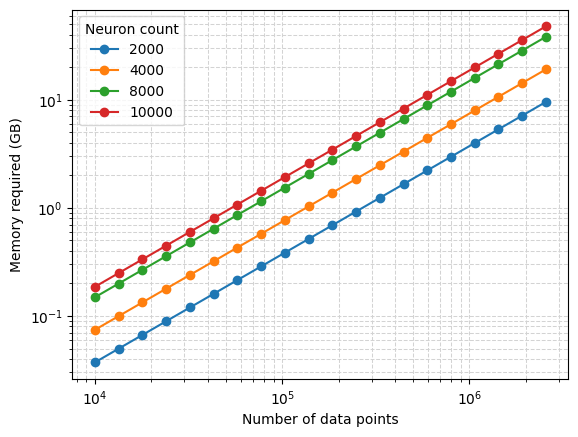

In [473]:
n_neurons = [2000, 4000, 8000, 10000]
n_data_points = 10_000 * 2 ** np.linspace(0, 8, 20)
for n in n_neurons:
    plt.plot(n_data_points, (n_data_points * n * 2) / 2**30, label=n, marker='o')
plt.legend(title='Neuron count')
plt.xlabel('Number of data points')
plt.ylabel('Memory required (GB)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', axis='both', color='lightgray', linestyle='--', linewidth=0.75)

In [469]:
10_000 * 2 ** np.linspace(0, 8, 20)

array([  10000.        ,   13389.04101224,   17926.64192276,
         24002.05439156,   32136.44906268,   43027.62344881,
         57609.86150155,   77134.0798354 ,  103275.13583579,
        138275.50292506,  185137.63796524,  247881.54276266,
        331889.61422278,  444368.36563669,  594966.62720538,
        796603.25725698, 1066575.36819014, 1428042.13473478,
       1912011.47091774, 2560000.        ])

In [174]:
print_minmax_activations_for_token(80, activation_df, feature_dataset, model, top_k=50)

########### Activations for 80: "o" ###########
### Max activations for 80: "o" ###
BEGIN (2.689453125): ], the magnet|o|elastic anisotropy along \[
BEGIN (2.671875):  exhibits the magnet|o|-electric effect,
BEGIN (2.6640625):  scaling of magnet|o|-transport, with
BEGIN (2.626953125):  on the magnet|o|-hydrodynamics simulations
BEGIN (2.59765625):  of strong magnet|o|-elastic coupling in
BEGIN (2.58984375):  using a magnet|o|-optical storage medium
BEGIN (2.583984375):  a large magnet|o|-optical trap (
BEGIN (2.576171875):  classical anisotropic magnet|o|-resistance phenomena,
BEGIN (2.560546875): ography, magnet|o|encephalography, near
BEGIN (2.55859375):  the continuum magnet|o|-mechanics
BEGIN (2.529296875):  origin of magnet|o|-oscillations
BEGIN (2.521484375):  lowers the magnet|o|elastic anisotropy energy along
BEGIN (2.5078125):  authors, magnet|o|-centrifugal
BEGIN (2.4921875):  from the magnet|o|-optic region.
BEGIN (2.482421875):  which six magnet|o|-electric conversion eleme

In [474]:
PYTHIA_70M_L1_N111_STIMULI = {
    12299: [[(13804,), (9432,)]],  # e.g. {Har, har}|vard
    35476: [[(43950, 762, 253), (3567, 762, 253)], [(2256, 281, 253)]],  # Boost
    20740: [[(2058, 253, 5403), (3404, 253, 5403)]],  # census
    26268: [[(15, 12332, 9824)], [(32170, 9824)]],  # Chain
    412: [[(47678, ), (14029, )]],  # op
    20000: [[(38476, 5625)]],  # Peace
    3621: [[(47694, )]],  # lease
    13606: [[(5625, 330)]],  # oven
    14894: [[(12602, 273, 15123)]],  # hma
    2616: [[(4335, )], [(29602, )]],  # factors
    7736: [[(21698, )]],  # pogenic
    39098: [[(4146, 12761), (14594, 12761)]],  # systems
    4412: [[(11586, 2077)]],  # District
    15353: [[(36642, )]],  # gate
    11845: [[(19256, 38056)]],  # iallance
    4694: [[(47678, ), (14029, )]],  # vision
    20310: [[(5625, 10518), (22817, 10518)]],  # Mach
    6875: [[(7671, ), (31351, )]],  # Science
    17629: [[(6399, )]],  # ograms
    19934: [[(35654, 15)], [(2700, 15)]],  # apple
    48862: [[(45590, 64)]],  # AUX
    7404: [[(749, ), (2377, )]],  # process
    35437: [[(22817, 13940), (5625, 13940)]],  # communication
    7662: [[(2359, 412), (22468, 412)]],  # roduction
    25837: [[(681, 16)]],  # fw
    16240: [[(21034, )], [(20709, )]],  # ington
}

In [545]:
feature_dataset = load_feature_dataset(dataset_name)

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [548]:
token_vector = feature_dataset['tokens'].flatten()


(649011, 2)

In [601]:

#probe_token, stimulus_class = 20740, [[(2058, 253, 5403), (3404, 253, 5403)]]  # ograms
stimulus_datasets = []
for probe_token, stimulus_class in PYTHIA_70M_L1_N111_STIMULI.items():
    #just take first class for simplicity (should be the strongest activating)
    stimulus = stimulus_class[0]

    probe_token_indices = torch.where(token_vector == probe_token)[0]

    valid_stimulus_indices = []
    for stimuli in stimulus:
        valid_stimuli_probe_indices = probe_token_indices
        for ix, t in enumerate(stimuli[::-1]):
            offset = ix + 1
            probe_indices_with_correct_stimuli_prefix = np.where(
                token_vector[valid_stimuli_probe_indices - offset] == t)[0]
            valid_stimuli_probe_indices = valid_stimuli_probe_indices[probe_indices_with_correct_stimuli_prefix]
        valid_stimulus_indices.append(valid_stimuli_probe_indices)
    valid_stimulus_indices = np.concatenate(valid_stimulus_indices)
    valid_negative_stimulus_indices = np.setdiff1d(probe_token_indices, valid_stimulus_indices)

    target_n_positive = min(500, len(valid_stimulus_indices))
    target_n_negative = min(2000, len(valid_negative_stimulus_indices))
    ctx_len = 32

    positive_indices = np.sort(np.random.choice(valid_stimulus_indices, target_n_positive, replace=False))
    negative_indices = np.sort(np.random.choice(valid_negative_stimulus_indices, target_n_negative, replace=False))
    len(positive_indices), len(negative_indices)

    positive_stimulus_token_tensor = np.vstack([
        token_vector[ix+1-ctx_len: ix+1] for ix in positive_indices
    ])
    negative_stimulus_token_tensor = np.vstack([
        token_vector[ix+1-ctx_len: ix+1] for ix in negative_indices
    ])
    stimulus_token_tensor = np.vstack([
        positive_stimulus_token_tensor, negative_stimulus_token_tensor
    ])

    token_name = model.tokenizer.decode(probe_token)
    feature_prefix = model.tokenizer.decode(list(stimulus[0]))
    feature_name = f'{feature_prefix}|{token_name}|'
    labels = ['positive' for _ in range(len(positive_indices))] + ['negative' for _ in range(len(negative_indices))]

    stimulus_ds = datasets.Dataset.from_dict({
        'tokens': stimulus_token_tensor,
        'label': labels,
        'feature_name': [feature_name for _ in range(len(labels))]
    }).shuffle()
    stimulus_datasets.append(stimulus_ds)
    print(f'Finished token {probe_token} {feature_name} with {len(positive_indices)} positive and {len(negative_indices)} negative stimuli')

neuron_stimulus_dataset = datasets.concatenate_datasets(stimulus_datasets)
neuron_stimulus_dataset.set_format(type="torch")


Finished token 12299 Har|vard| with 500 positive and 203 negative stimuli
Finished token 35476  Distributed under the| Boost| with 235 positive and 526 negative stimuli
Finished token 20740  At the 2006| census| with 177 positive and 1736 negative stimuli
Finished token 26268 .ApplicationFilter|Chain| with 67 positive and 736 negative stimuli
Finished token 412 Euro|op| with 94 positive and 2000 negative stimuli
Finished token 20000  Stockholm International| Peace| with 10 positive and 2000 negative stimuli
Finished token 3621  autore|lease| with 73 positive and 310 negative stimuli
Finished token 13606  International C|oven| with 20 positive and 1832 negative stimuli
Finished token 14894  Study of Ast|hma| with 5 positive and 834 negative stimuli
Finished token 2616  prime| factors| with 500 positive and 2000 negative stimuli
Finished token 7736  anthrop|ogenic| with 213 positive and 2000 negative stimuli
Finished token 39098  Sun Micro|systems| with 108 positive and 615 negative stim

In [602]:
neuron_stimulus_dataset = datasets.concatenate_datasets(stimulus_datasets)
neuron_stimulus_dataset.set_format(type="torch")


In [ ]:
stimulus_ds.set_format(type="torch")


In [567]:
probe_token_indices = torch.where(token_vector == probe_token)[0]

valid_stimulus_indices = []
for stimuli in stimulus:
    valid_stimuli_probe_indices = probe_token_indices
    for ix, t in enumerate(stimuli[::-1]):
        offset = ix + 1
        probe_indices_with_correct_stimuli_prefix = np.where(
            token_vector[valid_stimuli_probe_indices - offset] == t)[0]
        valid_stimuli_probe_indices = valid_stimuli_probe_indices[probe_indices_with_correct_stimuli_prefix]
    print(len(valid_stimuli_probe_indices))
    valid_stimulus_indices.append(valid_stimuli_probe_indices)
valid_stimulus_indices = np.concatenate(valid_stimulus_indices)
valid_negative_stimulus_indices = np.setdiff1d(probe_token_indices, valid_stimulus_indices)

172
5


(177, 1736)

In [598]:
ctx_len = 32
positive_stimulus_token_tensor = np.vstack([
    token_vector[ix+1-ctx_len: ix+1] for ix in positive_indices
])
negative_stimulus_token_tensor = np.vstack([
    token_vector[ix+1-ctx_len: ix+1] for ix in negative_indices
])
stimulus_token_tensor = np.vstack([
    positive_stimulus_token_tensor, negative_stimulus_token_tensor
])

token_name = model.tokenizer.decode(probe_token)
feature_prefix = model.tokenizer.decode(list(stimulus[0]))
feature_name = f'{feature_prefix}|{token_name}|'
labels = ['positive' for _ in range(len(positive_indices))] + ['negative' for _ in range(len(negative_indices))]

stimulus_ds = datasets.Dataset.from_dict({
    'tokens': stimulus_token_tensor,
    'label': labels,
    'feature_name': [feature_name for _ in range(len(labels))]
}).shuffle()
stimulus_ds.set_format(type="torch")


In [588]:
len(set([tuple(row) for row in positive_stimulus_token_tensor]))

170

In [591]:
stimulus_token_tensor.shape

(1913, 32)

In [28]:
ls feature_datasets

compound_words.pyth.16.-1/       natural_lang_id.pyth.512.-1/
compound_words.pyth.512.-1/      natural_lang_id.pyth.512.100/
counterfact.pyth.64.-1/          neuron_stimulus.pyth.512.-1/
counterfact.pyth.64.100/         pile_test.pyth.512.-1/
distribution_id.pyth.512.-1/     programming_lang_id.pyth.512.-1/
has_prefix.pyth.512.-1/          text_features.pyth.512.-1/
has_suffix.pyth.512.-1/


In [30]:
fds = load_feature_dataset('neuron_stimulus.pyth.512.-1')

In [31]:
fds

Dataset({
    features: ['tokens', 'label', 'feature_name'],
    num_rows: 39116
})

In [33]:
fds['tokens'].shape

torch.Size([39116, 32])

In [41]:
(39116 * (512 * 4) * 2) / 2**20

152.796875

In [40]:
(39116 * 32 * 6 * (512 * 4) * 2) / 2**30

28.6494140625

In [42]:
for t, v in zip(*np.unique(token_vector[probe_token_indices-1].numpy(), return_counts=True)):
    if v > 500:
        print(model.tokenizer.decode(t), v)

NameError: name 'token_vector' is not defined

In [510]:
token_vector = feature_dataset['tokens'].flatten()

In [530]:
probe_token_indices = torch.where(token_vector == probe_token)[0]
set(probe_token_indices.numpy())

{112810,
 112950,
 470487,
 2185485,
 2185577,
 2185585,
 2185754,
 2965781,
 2967637,
 3417999,
 3776047,
 4688467,
 5813026,
 5828139,
 5829401,
 5829781,
 6050238,
 6053387,
 6053910,
 6053951,
 6054067,
 6055474,
 6056743,
 6059536,
 6063184,
 6064407,
 6066115,
 6067037,
 7173315,
 8562568,
 8562799,
 8562819,
 8563058,
 8563091,
 8563140,
 8563423,
 8563461,
 8564073,
 8565741,
 8566365,
 8567411,
 8567455,
 8568809,
 8568869,
 8568885,
 8576016,
 8576247,
 8630238,
 8630578,
 8630716,
 8630855,
 8659500,
 9095563,
 9095643,
 9095663,
 9095810,
 9098166,
 9099564,
 9099838,
 9099846,
 9103575,
 9103668,
 9103901,
 9104584,
 9104809,
 9105274,
 9105403,
 10479230,
 11393960,
 12573500,
 12845454,
 12845457,
 12845766,
 14662091,
 14662224,
 14662284,
 14662762,
 14662814,
 15227189,
 15953252,
 17218301,
 18549531,
 18549683,
 18549836,
 18708502,
 19241287,
 19241306,
 19985449,
 19990789,
 22921293,
 22921821,
 22921983,
 23433424,
 25066405,
 25417178,
 25425483,
 25427518,
 25

In [512]:
valid_stimulus_indices

set()

In [23]:
ds = load_feature_dataset('compound_words.pyth.16.-1')

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [25]:
ds

Dataset({
    features: ['tokens', 'label', 'feature_name'],
    num_rows: 219138
})

In [27]:
print(ds[0]['tokens'])

tensor([48514,  1381,    22,   937, 42022, 48514,  7474,  6302,    22,  6624,
        44991,  1381,  5456,   937,  8656, 22850])
